In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from textblob import TextBlob
import matplotlib.pyplot as plt
# Download NLTK resources
#nltk.download('punkt')
#nltk.download('stopwords')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Flatten, Dropout,Conv1D, GlobalMaxPooling1D,GRU,  Lambda
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
import keras_tuner as kt
from transformers import GPT2Tokenizer, TFGPT2Model
import tensorflow as tf
# Assume reviews.csv columns: UserID, MovieID, ReviewText, Rating

In [3]:
import pandas as pd
from sqlalchemy import create_engine

# Define your PostgreSQL connection parameters
db_user = 'postgres'
db_password = 'admin'
db_host = 'localhost'
db_port = '5433'
db_name = 'postgres'

# Create a SQLAlchemy engine to connect to the PostgreSQL database
engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')




In [5]:
# Define your SQL query. You can modify this query to filter rows as needed.
query = """
SELECT *
FROM playstore_game_reviews
LIMIT 100000;  -- adjust this limit based on your memory and needs
"""

# Read the query results into a DataFrame
df = pd.read_sql(query, engine)

print("Subset of data loaded into DataFrame:")
print(df.head())


Subset of data loaded into DataFrame:
                           title  \
0  Grand Theft Auto: San Andreas   
1  Grand Theft Auto: San Andreas   
2  Grand Theft Auto: San Andreas   
3  Grand Theft Auto: San Andreas   
4  Grand Theft Auto: San Andreas   

                                         description  \
0  Five years ago, Carl Johnson escaped from the ...   
1  Five years ago, Carl Johnson escaped from the ...   
2  Five years ago, Carl Johnson escaped from the ...   
3  Five years ago, Carl Johnson escaped from the ...   
4  Five years ago, Carl Johnson escaped from the ...   

                         summary  minInstalls   genre      genreId  \
0  Grand Theft Auto: San Andreas      1000000  Action  GAME_ACTION   
1  Grand Theft Auto: San Andreas      1000000  Action  GAME_ACTION   
2  Grand Theft Auto: San Andreas      1000000  Action  GAME_ACTION   
3  Grand Theft Auto: San Andreas      1000000  Action  GAME_ACTION   
4  Grand Theft Auto: San Andreas      1000000  Action  GAM

In [7]:
df.head()

,title,description,summary,minInstalls,genre,genreId,appId,reviewId,userName,content,score
0,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOHc4bk4qFmjn6UVlvGvDQnrl4MPfI4eoVHkeVh...,jerrod carson,Well it was an amazing game until one day it j...,1
1,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOF51K5A6irQCgu2hLvoeUef1Ctzwwgokay01QJ...,Jose Quintero,"When using a gamepad, I cannot move the cursor...",1
2,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOFPaxDYBnoFlcSA8VSevfID1LO58mjz6IGs4Mu...,Chintan Sureliya,Have played this game earlier several times on...,1
3,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOFf5_Hy2Slvh4lZPi3oXq51yKnDmnjfbbtqFXq...,Marty Mayfield,I really wanted to like this game. The control...,1
4,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOEktSrayZreOdojT7bKWI3OOTavr0GbEDFzUOy...,joesph young,The app keeps stopping it's not even playable ...,1


In [9]:
df.describe()

,minInstalls,score
count,1.000000e+05,100000.000000
mean,2.120156e+06,3.280300
std,3.350316e+06,1.531508
min,5.000000e+03,1.000000
25%,5.000000e+05,2.000000
50%,1.000000e+06,4.000000
75%,1.000000e+06,5.000000
max,1.000000e+07,5.000000


In [11]:
df.head()

,title,description,summary,minInstalls,genre,genreId,appId,reviewId,userName,content,score
0,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOHc4bk4qFmjn6UVlvGvDQnrl4MPfI4eoVHkeVh...,jerrod carson,Well it was an amazing game until one day it j...,1
1,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOF51K5A6irQCgu2hLvoeUef1Ctzwwgokay01QJ...,Jose Quintero,"When using a gamepad, I cannot move the cursor...",1
2,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOFPaxDYBnoFlcSA8VSevfID1LO58mjz6IGs4Mu...,Chintan Sureliya,Have played this game earlier several times on...,1
3,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOFf5_Hy2Slvh4lZPi3oXq51yKnDmnjfbbtqFXq...,Marty Mayfield,I really wanted to like this game. The control...,1
4,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOEktSrayZreOdojT7bKWI3OOTavr0GbEDFzUOy...,joesph young,The app keeps stopping it's not even playable ...,1


In [13]:
# Standard English stopwords
standard_stopwords = set(stopwords.words('english'))

# Domain-specific stopwords for movie reviews (extend as needed)
domain_stopwords = {"game", "app", "play", "install","downloads"}

# Combined stopwords
all_stopwords = standard_stopwords.union(domain_stopwords)

# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_review(text, method='lemmatization', do_spell_correction=True, min_words=3):
    """
    Clean and normalize text reviews.
    
    Parameters:
      - text: the input review text.
      - method: choose between 'lemmatization' or 'stemming'.
      - do_spell_correction: if True, apply spell correction using TextBlob.
      - min_words: minimum number of words required; otherwise, return empty string.
    
    Returns:
      Cleaned text.
    """
    # Handle missing or non-string values
    if not isinstance(text, str):
        return ""
    
    # Remove HTML tags if any
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', ' ', text).lower()
    
    # Optionally perform spell correction (Note: can be slow on large datasets)
    #if do_spell_correction:
     #   try:
     #       text = str(TextBlob(text).correct())
     #   except Exception as e:
     #       # In case spell correction fails, use the original text.
     #       pass
    
    # Tokenize text
    tokens = text.split()
    
    # Filter out tokens that are in our stopwords list
    tokens = [word for word in tokens if word not in all_stopwords]
    
    # Ensure the review has a minimum number of words; otherwise, mark as empty.
    if len(tokens) < min_words:
        return ""
    
    # Apply stemming or lemmatization as desired
    if method == 'stemming':
        tokens = [stemmer.stem(word) for word in tokens]
    else:  # default is lemmatization
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)

# Example usage on your DataFrame:
# Replace 'text' with the appropriate column name in your dataset
df['cleaned_review'] = df['content'].apply(clean_review)
df.head()

,title,description,summary,minInstalls,genre,genreId,appId,reviewId,userName,content,score,cleaned_review
0,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOHc4bk4qFmjn6UVlvGvDQnrl4MPfI4eoVHkeVh...,jerrod carson,Well it was an amazing game until one day it j...,1,well amazing one day stopped working everytime...
1,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOF51K5A6irQCgu2hLvoeUef1Ctzwwgokay01QJ...,Jose Quintero,"When using a gamepad, I cannot move the cursor...",1,using gamepad cannot move cursor anywhere righ...
2,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOFPaxDYBnoFlcSA8VSevfID1LO58mjz6IGs4Mu...,Chintan Sureliya,Have played this game earlier several times on...,1,played earlier several time pc really easy mob...
3,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOFf5_Hy2Slvh4lZPi3oXq51yKnDmnjfbbtqFXq...,Marty Mayfield,I really wanted to like this game. The control...,1,really wanted like control beyond irritating g...
4,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOEktSrayZreOdojT7bKWI3OOTavr0GbEDFzUOy...,joesph young,The app keeps stopping it's not even playable ...,1,keep stopping even playable want money back pl...


In [15]:
sid = SentimentIntensityAnalyzer()

def get_sentiment_rating(text):
    sentiment = sid.polarity_scores(text)
    # VADER compound score is in [-1, 1]. We'll map it to a 1-5 scale.
    compound = sentiment['compound']
    rating = np.interp(compound, [-1, 1], [1, 5])
    return rating

In [17]:
if 'rating' not in df.columns or df['rating'].isnull().any():
    df['inferred_rating'] = df['cleaned_review'].apply(get_sentiment_rating)
    df['rating'] = df['inferred_rating']
    


In [19]:
df.head(10)

,title,description,summary,minInstalls,genre,genreId,appId,reviewId,userName,content,score,cleaned_review,inferred_rating,rating
0,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOHc4bk4qFmjn6UVlvGvDQnrl4MPfI4eoVHkeVh...,jerrod carson,Well it was an amazing game until one day it j...,1,well amazing one day stopped working everytime...,4.4860,4.4860
1,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOF51K5A6irQCgu2hLvoeUef1Ctzwwgokay01QJ...,Jose Quintero,"When using a gamepad, I cannot move the cursor...",1,using gamepad cannot move cursor anywhere righ...,4.4368,4.4368
2,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOFPaxDYBnoFlcSA8VSevfID1LO58mjz6IGs4Mu...,Chintan Sureliya,Have played this game earlier several times on...,1,played earlier several time pc really easy mob...,4.4178,4.4178
3,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOFf5_Hy2Slvh4lZPi3oXq51yKnDmnjfbbtqFXq...,Marty Mayfield,I really wanted to like this game. The control...,1,really wanted like control beyond irritating g...,3.2268,3.2268
4,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOEktSrayZreOdojT7bKWI3OOTavr0GbEDFzUOy...,joesph young,The app keeps stopping it's not even playable ...,1,keep stopping even playable want money back pl...,3.9558,3.9558
5,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOG-g1U_ti4680ArFIvjhCCsFvBkou1k279MKgh...,Pac Man,Let's hope it works better 🙏 ken use Fix your ...,1,let hope work better ken use fix say new updat...,4.8786,4.8786
6,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOHVuxYr5t_9wfeO1jydmxu0jD_RQxzo0IDUMJ_...,clayton0127,"Absolutely horrible. It crashes randomly, whic...",1,absolutely horrible crash randomly doesnt happ...,1.1888,1.1888
7,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOEve6pYDz-wHsTiVs08EUyUpYq1KsbKTG5RJXV...,Ashish Singh,The vehicles seem to drag in one direction whi...,1,vehicle seem drag one direction make flying dr...,1.4852,1.4852
8,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOFSR_ASJVPpGTh8IGJrSHqPysdUjD0sWJ55wnB...,Walty Walt,"One big issue in this game is that, when an ex...",1,one big issue external keyboard connected pres...,3.6364,3.6364
9,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOGA5FHvk6tbvbqJxnKKtDHzUYk3NbK_tsjHWP4...,Craig Johnson,"It stuck at the ""mike toreno"" mission..when i ...",1,stuck mike toreno mission finished shooting va...,3.2054,3.2054


In [21]:
# Create mappings for user and app IDs:
user_ids = df['userName'].unique().tolist()   # using userName
app_ids = df['appId'].unique().tolist()         # using appId

user2idx = {user: idx for idx, user in enumerate(user_ids)}
app2idx = {app: idx for idx, app in enumerate(app_ids)}

df['user_idx'] = df['userName'].map(user2idx)
df['app_idx'] = df['appId'].map(app2idx)



In [23]:

# For example:
max_vocab = 10000
max_length = 200

tokenizer = Tokenizer(num_words=max_vocab, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_review'])
df['review_seq'] = tokenizer.texts_to_sequences(df['cleaned_review'])
df['review_seq'] = pad_sequences(df['review_seq'], maxlen=max_length).tolist()




In [25]:
# Prepare training data:
X_user = np.array(df['user_idx'].tolist())
X_app = np.array(df['app_idx'].tolist())
X_review = np.array(df['review_seq'].tolist())
y = np.array(df['rating'].tolist())

print("User input shape:", X_user.shape)
print("App input shape:", X_app.shape)
print("Review input shape:", X_review.shape)
print("Ratings shape:", y.shape)


User input shape: (100000,)
App input shape: (100000,)
Review input shape: (100000, 200)
Ratings shape: (100000,)


In [27]:
from sklearn.model_selection import train_test_split
X_user_train, X_user_test, X_app_train, X_app_test, X_review_train, X_review_test, y_train, y_test = train_test_split(
    X_user, X_app, X_review, y, test_size=0.2, random_state=42
)

In [29]:
num_users = len(user2idx)
num_apps = len(app2idx)



In [31]:
# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        # Create the Dense layer here so that variables are created once.
        self.att_dense = Dense(1, activation='tanh')

    def call(self, inputs):
        # Compute a score for each time step
        score = self.att_dense(inputs)  # shape (batch, timesteps, 1)
        # Squeeze the last dimension and apply softmax over time axis
        attention_weights = tf.nn.softmax(tf.squeeze(score, axis=-1), axis=1)  # shape (batch, timesteps)
        # Expand dims so that we can multiply by inputs
        attention_weights = tf.expand_dims(attention_weights, axis=-1)  # shape (batch, timesteps, 1)
        # Weighted sum of inputs over time axis
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)  # shape (batch, features)
        return context_vector

In [33]:
def mla_edtcnet_model(hp):
    # Define the review input (sequence of token IDs)
    review_input = Input(shape=(max_length,), name='review_input')
    
    # Add an Embedding layer for the reviews.
    embedding_dim = hp.Choice('review_embedding_dim', values=[50, 100, 150])
    review_embedding = Embedding(input_dim=max_vocab, 
                                 output_dim=embedding_dim, 
                                 input_length=max_length, 
                                 name='review_embedding')(review_input)
    
    # Encoder: GRU layer for sequential encoding.
    encoder_units = hp.Choice('encoder_units', values=[64, 128, 150])
    encoder_output = GRU(encoder_units, return_sequences=True, name='encoder_gru')(review_embedding)
    
    # Temporal Convolution: Conv1D layer to capture local features.
    conv_filters = hp.Choice('conv_filters', values=[64, 128, 256])
    conv_kernel_size = hp.Choice('conv_kernel_size', values=[3, 5])
    conv_output = Conv1D(filters=conv_filters, kernel_size=conv_kernel_size, activation='relu', name='conv1d')(encoder_output)
    
    # Use the custom AttentionLayer instead of a Lambda.
    review_vector = AttentionLayer(name='attention_layer')(conv_output)
    
    # User and App inputs and embeddings 
    user_input = Input(shape=(1,), name='user_input')
    app_input = Input(shape=(1,), name='app_input')
    
    user_embedding_dim = hp.Choice('user_embedding_dim', values=[8, 10, 12])
    user_embedding = Embedding(input_dim=len(user2idx), output_dim=user_embedding_dim, name='user_embedding')(user_input)
    user_vec = Flatten(name='user_flatten')(user_embedding)
    
    app_embedding_dim = hp.Choice('app_embedding_dim', values=[8, 10, 12])
    app_embedding = Embedding(input_dim=len(app2idx), output_dim=app_embedding_dim, name='app_embedding')(app_input)
    app_vec = Flatten(name='app_flatten')(app_embedding)
    
    # Concatenate all features
    concat = Concatenate(name='concatenate')([user_vec, app_vec, review_vector])
    
    # Dense layers
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    dense1 = Dense(dense_units, activation='relu', name='dense1')(concat)
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    dropout_layer = Dropout(dropout_rate, name='dropout')(dense1)
    output = Dense(1, activation='linear', name='rating_prediction')(dropout_layer)
    
    model = Model(inputs=[user_input, app_input, review_input], outputs=output)
    
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

In [35]:
tuner = kt.RandomSearch(
    lambda hp: mla_edtcnet_model(hp),
    objective='val_loss',
    max_trials=10,
    directory='mla_edtcnet_tuner',
    project_name='mla_edtcnet_app_reviews'
)

tuner.search([X_user_train, X_app_train, X_review_train], y_train,
             validation_split=0.1,
             epochs=5,
             batch_size=64)




Trial 10 Complete [00h 12m 28s]
val_loss: 0.7468462586402893

Best val_loss So Far: 0.043323926627635956
Total elapsed time: 05h 12m 53s


In [37]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps.values)

Best hyperparameters: {'review_embedding_dim': 50, 'encoder_units': 150, 'conv_filters': 256, 'conv_kernel_size': 3, 'user_embedding_dim': 10, 'app_embedding_dim': 8, 'dense_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.0007935592341237341}


In [39]:

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit([X_user_train, X_app_train, X_review_train],
                         y_train,
                         validation_split=0.1,
                         epochs=10,
                         batch_size=64)

C:\Users\alanb\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 308s 270ms/step - loss: 1.6370 - mae: 0.9846 - val_loss: 0.1781 - val_mae: 0.3056
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 372s 330ms/step - loss: 0.4762 - mae: 0.5299 - val_loss: 0.0963 - val_mae: 0.2200
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 372s 331ms/step - loss: 0.3238 - mae: 0.4365 - val_loss: 0.0872 - val_mae: 0.2155
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 376s 335ms/step - loss: 0.2442 - mae: 0.3728 - val_loss: 0.0609 - val_mae: 0.1702
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 364s 324ms/step - loss: 0.1711 - mae: 0.3088 - val_loss: 0.0455 - val_mae: 0.1290
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 369s 328ms/step - loss: 0.1289 - mae: 0.2655 - val_loss: 0.0485 - val_mae: 0.1473
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 376s 334ms/step - loss: 0.1085 - mae: 0.2401 - val_loss: 0.0433 - val_mae: 0.1343
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 375s 334ms/step - loss: 0.0914 - mae: 0.2180 - val_loss: 0.0429 - val_mae: 0.1348
Epoch 9/

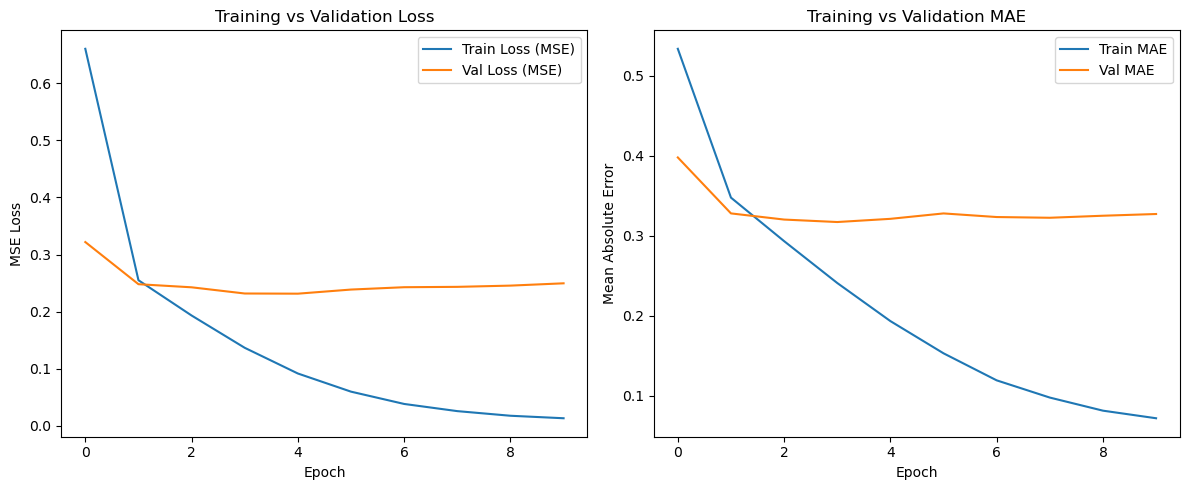

In [102]:
import matplotlib.pyplot as plt



plt.figure(figsize=(12, 5))

# Plot training vs validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Plot training vs validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()



In [41]:
loss, mae = best_model.evaluate([X_user_test, X_app_test, X_review_test], y_test)
print(f"Test MSE: {loss:.4f}, Test MAE: {mae:.4f}")



625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - loss: 0.0392 - mae: 0.1244
Test MSE: 0.0391, Test MAE: 0.1239


In [43]:

# Generate predictions and perform error analysis (plots, etc.)
y_pred = best_model.predict([X_user_test, X_app_test, X_review_test]).flatten()




625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step


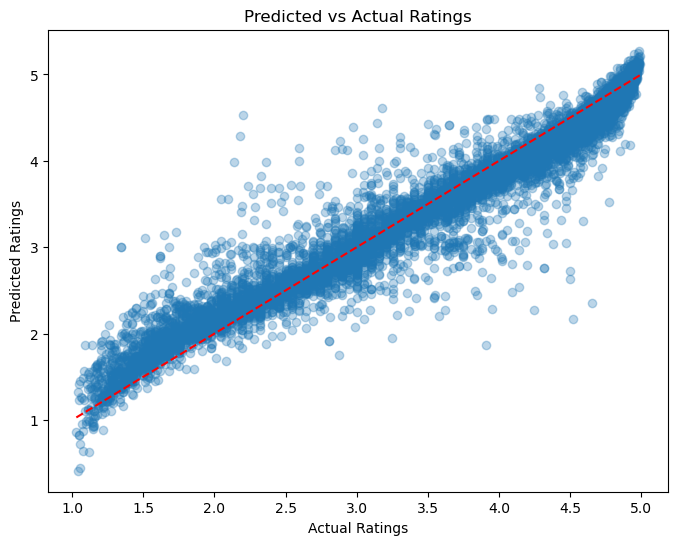

In [45]:

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # reference line
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs Actual Ratings')
plt.show()


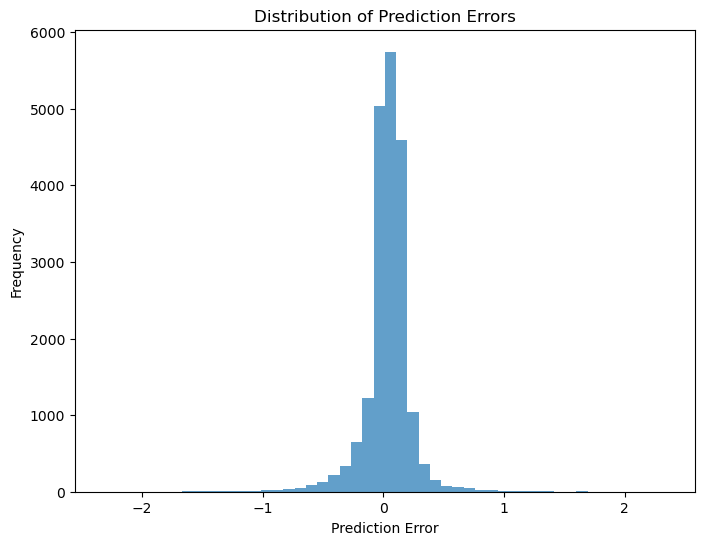

In [47]:

errors = y_test - y_pred


plt.figure(figsize=(8, 6))
plt.hist(errors, bins=50, alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

In [49]:
# Create a DataFrame to inspect predictions.
test_df = pd.DataFrame({
    'user': X_user_test,
    'app': X_app_test,
    'true_rating': y_test,
    'predicted_rating': y_pred
})
print(test_df.head())

    user  app  true_rating  predicted_rating
0  26121   29       4.7440          4.647838
1     86   32       3.0000          3.004192
2  17630    8       4.6884          4.553462
3  67834   39       3.6364          3.598656
4  45572   43       3.0000          2.890248


In [53]:
import numpy as np

# Example: Calculate ranking metrics (Precision@10, Recall@10, NDCG@10)
def precision_recall_ndcg(test_df, k=10, relevance_threshold=3.0):
    import numpy as np
    user_groups = test_df.groupby('user')
    precisions, recalls, ndcgs = [], [], []
    for user, group in user_groups:
        group_sorted = group.sort_values('predicted_rating', ascending=False)
        top_k = group_sorted.head(k)
        relevant = (top_k['true_rating'] >= relevance_threshold).astype(int).values
        num_relevant_in_top_k = relevant.sum()
        precision = num_relevant_in_top_k / k
        total_relevant = (group['true_rating'] >= relevance_threshold).sum()
        recall = num_relevant_in_top_k / total_relevant if total_relevant > 0 else 0.0
        dcg = sum([(2**rel - 1) / np.log2(idx + 2) for idx, rel in enumerate(relevant)])
        ideal_relevances = group['true_rating'].apply(lambda x: 1 if x >= relevance_threshold else 0)
        ideal_sorted = ideal_relevances.sort_values(ascending=False).head(k).values
        idcg = sum([(2**rel - 1) / np.log2(idx + 2) for idx, rel in enumerate(ideal_sorted)])
        ndcg = dcg / idcg if idcg > 0 else 0.0
        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)
    return np.mean(precisions), np.mean(recalls), np.mean(ndcgs)


In [55]:
# Assume you have already generated predictions (y_pred) and created test_df
# Set k (e.g., 10) and a relevance threshold (e.g., 4.0)
k = 10
relevance_threshold = 3.0
avg_precision, avg_recall, avg_ndcg = precision_recall_ndcg(test_df, k=k, relevance_threshold=relevance_threshold)
print(f"Precision@{k}: {avg_precision:.4f}")
print(f"Recall@{k}: {avg_recall:.4f}")
print(f"NDCG@{k}: {avg_ndcg:.4f}")


Precision@10: 0.0838
Recall@10: 0.8231
NDCG@10: 0.8231


In [57]:
# Mapping app IDs to titles
app_id_to_title = df[['appId', 'title']].drop_duplicates().set_index('appId')['title'].to_dict()


In [59]:
# Example: Recommend top apps for a sample user
sample_user = 7
all_app_indices = np.array(list(range(len(app2idx))))
sample_user_input = np.full(shape=(len(app2idx),), fill_value=sample_user)
default_review_seq = np.zeros((len(app2idx), max_length), dtype=int)  # placeholder for review input
predicted_ratings = best_model.predict([sample_user_input, all_app_indices, default_review_seq]).flatten()
recommended_app_indices = np.argsort(predicted_ratings)[::-1][:10]

recommended_app_titles = [app_id_to_title[app_ids[i]] for i in recommended_app_indices]

print("Top recommended app titles for user", sample_user, "using transformer model:")
for title in recommended_app_titles:
    print(title)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
Top recommended app titles for user 7 using transformer model:
TL Pro
Carcassonne: Official Board Game -Tiles & Tactics
The Sun Origin: Post-apocalyptic action shooter
Through the Ages
60 Seconds! Atomic Adventure
Galaxy Warrior: Alien Attack
Cyber Fighters: League of Cyberpunk Stickman 2077
Worms 3
Hitman Sniper
LIMBO
